In [2]:
import delfi.distribution as dd
import delfi.generator as dg
import delfi.inference as infer
import delfi.utils.io as io
import delfi.summarystats as ds
import lfimodels.hodgkinhuxley.utils as utils
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pickle

from lfimodels.hodgkinhuxley.HodgkinHuxley import HodgkinHuxley
from lfimodels.hodgkinhuxley.HodgkinHuxleyStatsMoments import HodgkinHuxleyStatsMoments
from lfimodels.hodgkinhuxley.HodgkinHuxleyStatsSpikes_mf import HodgkinHuxleyStatsSpikes_mf
from delfi.utils.viz import plot_pdf

%matplotlib inline

In [3]:
def param_transform(prior_log, x):
    if prior_log:
        return np.log(x)
    else:
        return x

def param_invtransform(prior_log, x):
    if prior_log:
        return np.exp(x)
    else:
        return x

In [4]:
reduced_model = False
true_params, labels_params = utils.obs_params(reduced_model=reduced_model)

seed = 1
prior_uniform = True
prior_log = False
prior_extent = True
n_xcorr = 0
n_mom = 4
cython=True
n_summary = 8
summary_stats = 3

I, t_on, t_off, dt = utils.syn_current()

obs = utils.syn_obs_data(I, dt, true_params, seed=seed, cython=cython)
obs_stats = utils.syn_obs_stats(data=obs,I=I, t_on=t_on, t_off=t_off, dt=dt, params=true_params,
                                seed=seed, n_xcorr=n_xcorr, n_mom=n_mom, cython=cython,
                                summary_stats=summary_stats,n_summary=n_summary)


# define model, prior, summary statistics and generator
n_processes = 10

if n_processes>1:
    seeds_model = np.arange(1,n_processes+1,1)
    m = []
    for i in range(n_processes):
        m.append(HodgkinHuxley(I, dt, V0=obs['data'][0],reduced_model=reduced_model,
                               seed=seeds_model[i], cython=cython,prior_log=prior_log))
    p = utils.prior(true_params=true_params,prior_uniform=prior_uniform,
                    prior_extent=prior_extent,prior_log=prior_log, seed=seed)
#     s = HodgkinHuxleyStatsMoments(t_on=t_on, t_off=t_off)
    s = HodgkinHuxleyStatsSpikes_mf(t_on=t_on, t_off=t_off, n_summary=n_summary)
    g = dg.MPGenerator(models=m, prior=p, summary=s)
else:
    seed = None
    m = HodgkinHuxley(I, dt, V0=obs['data'][0],reduced_model=reduced_model,
                      seed=seed, cython=cython,prior_log=prior_log)
    p = utils.prior(true_params=true_params,prior_uniform=prior_uniform,
                    prior_extent=prior_extent,prior_log=prior_log, seed=seed)
#     s = HodgkinHuxleyStatsMoments(t_on=t_on, t_off=t_off)
    s = HodgkinHuxleyStatsSpikes_mf(t_on=t_on, t_off=t_off, n_summary=n_summary)
    g = dg.Default(model=m, prior=p, summary=s)

In [ ]:
seed = 1
svi = False
impute_missing = False
pilot_samples = 1000
n_sims = 5000
n_rounds = 2
n_components = 2
n_hiddens = [100]*2
res = infer.SNPE(g, obs=obs_stats, pilot_samples=pilot_samples, n_hiddens=n_hiddens, seed=seed, prior_norm=True,
                 n_components=n_components, svi=svi, impute_missing=impute_missing)

# run with N samples
log, train_data, posterior = res.run(n_sims, n_rounds=n_rounds, epochs=1000)

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

0/|/Draw parameters (pilot run) :   0%|| 0/1000 [00:00<?, ?it/s]


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

0/|/Run simulations (pilot run) :   0%|| 0/1000 [00:00<?, ?it/s]


HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

0/|/Draw parameters (round 1) :   0%|| 0/5000 [00:00<?, ?it/s]


HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

0/|/Run simulations (round 1) :   0%|| 0/5000 [00:00<?, ?it/s]

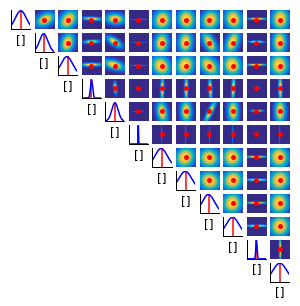

In [5]:
prior_min = res.generator.prior.lower
prior_max = res.generator.prior.upper
# prior_min = res.generator.prior.mean-res.generator.prior.std
# prior_max = res.generator.prior.mean+res.generator.prior.std


prior_lims = np.concatenate((prior_min.reshape(-1,1),
                                 prior_max.reshape(-1,1)),
                                axis=1)

for i in range(res.round):
    fig = plt.figure(figsize=(15,15))
    plot_pdf(posterior[i], lims=prior_lims, samples=None,figsize=(15,15),gt=param_transform(prior_log,true_params))
    plt.show()
    plt.close()